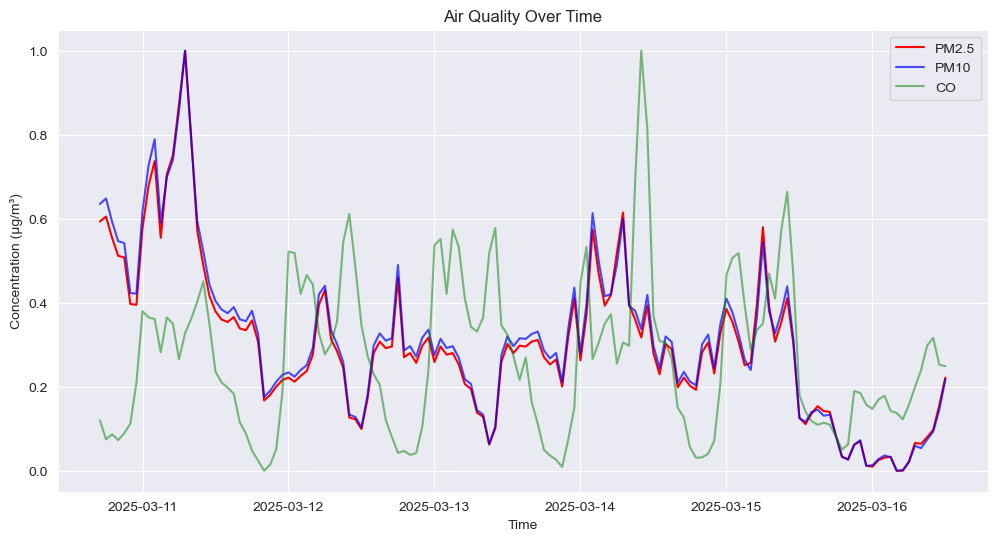

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu đã tiền xử lý
df = pd.read_csv("data/train_processed.csv", index_col=0, parse_dates=True)

# Vẽ biểu đồ thời gian của một số chỉ số quan trọng (PM2.5, PM10, CO)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["pm25 (µg/m³)"], label="PM2.5", color='red')
plt.plot(df.index, df["pm10 (µg/m³)"], label="PM10", color='blue', alpha=0.7)
plt.plot(df.index, df["co (µg/m³)"], label="CO", color='green', alpha=0.5)

plt.xlabel("Time")
plt.ylabel("Concentration (µg/m³)")
plt.title("Air Quality Over Time")
plt.legend()
plt.show()


Importing plotly failed. Interactive plots will not work.
23:32:14 - cmdstanpy - INFO - Chain [1] start processing
23:32:15 - cmdstanpy - INFO - Chain [1] done processing
/Users/mysorf/miniconda3/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
/Users/mysorf/miniconda3/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/mysorf/miniconda3/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain t

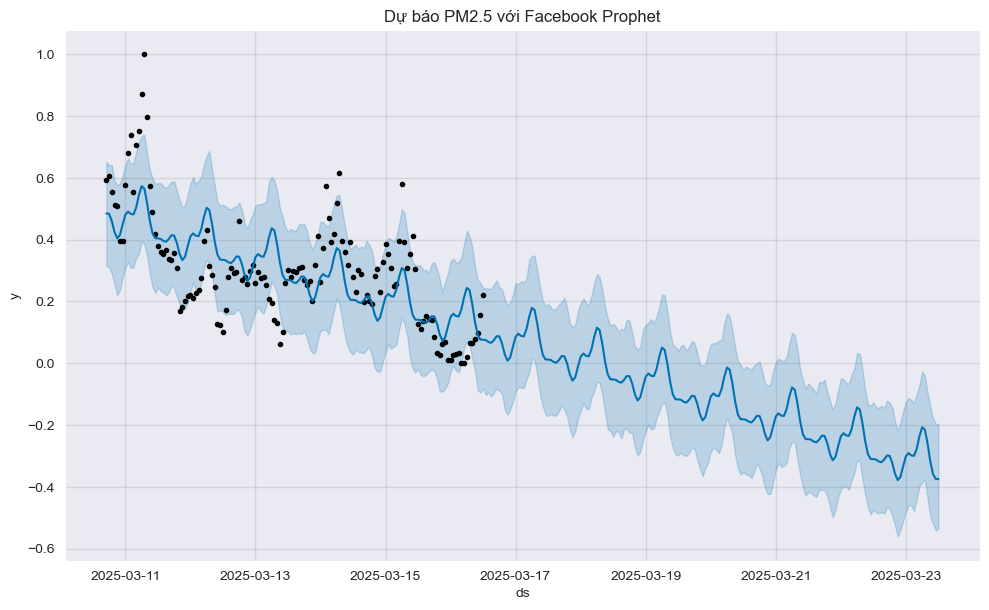

In [1]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Đọc dữ liệu đã xử lý
df = pd.read_csv("data/train_processed.csv")

# 2️⃣ Chuẩn bị dữ liệu cho Prophet (chỉ cần timestamp và PM2.5)
df_prophet = df[['timestamp', 'pm25 (µg/m³)']]
df_prophet.columns = ['ds', 'y']  # Prophet yêu cầu cột 'ds' (datetime) và 'y' (giá trị dự đoán)

# 3️⃣ Khởi tạo mô hình Prophet
model = Prophet()
model.fit(df_prophet)

# 4️⃣ Tạo tập dữ liệu để dự đoán (7 ngày tiếp theo)
future = model.make_future_dataframe(periods=24*7, freq='H')  # 7 ngày tới, mỗi giờ 1 điểm
forecast = model.predict(future)

# 5️⃣ Vẽ biểu đồ dự đoán
fig = model.plot(forecast)
plt.title("Dự báo PM2.5 với Facebook Prophet")
plt.show()

ADF Statistic: -2.468416532109343, p-value: 0.12334923243492407


/Users/mysorf/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/mysorf/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/mysorf/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/mysorf/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


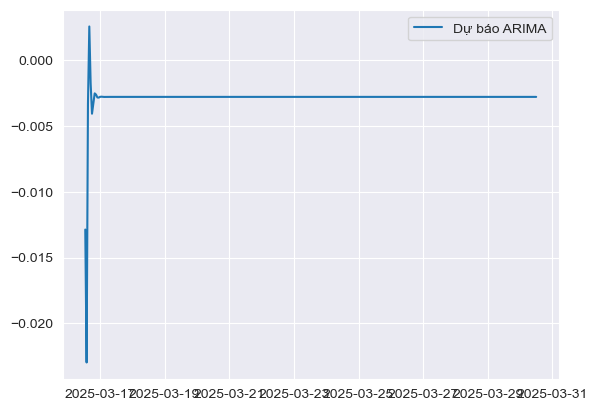

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# 1️⃣ Đọc dữ liệu
df = pd.read_csv("data/train_processed.csv", index_col="timestamp", parse_dates=True)

# 2️⃣ Chọn cột PM2.5
pm25 = df["pm25 (µg/m³)"]

# 3️⃣ Kiểm tra tính dừng (ADF Test)
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(pm25)
print(f"ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}")

# 4️⃣ Nếu không dừng, lấy sai phân bậc 1
if adf_test[1] > 0.05:
    pm25 = pm25.diff().dropna()

# 5️⃣ Huấn luyện mô hình ARIMA (p=2, d=1, q=2 - thử nghiệm)
model = ARIMA(pm25, order=(2, 1, 2))
model_fit = model.fit()

# 6️⃣ Dự đoán 7 ngày tới
forecast = model_fit.forecast(steps=24*7)
plt.plot(forecast, label="Dự báo ARIMA")
plt.legend()
plt.show()

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# 1️⃣ Đọc dữ liệu
df = pd.read_csv("data/train_processed.csv", index_col="timestamp", parse_dates=True)

# 2️⃣ Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
pm25_scaled = scaler.fit_transform(df[['pm25 (µg/m³)']])

# 3️⃣ Tạo dữ liệu dạng chuỗi thời gian (n_steps = 24 giờ)
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 24
X, y = create_sequences(pm25_scaled, n_steps)

# 4️⃣ Chia tập Train/Test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 5️⃣ Xây dựng mô hình LSTM
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# 6️⃣ Huấn luyện mô hình
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 7️⃣ Dự đoán
predictions = model.predict(X_test)

# 8️⃣ Chuyển đổi về giá trị gốc
predictions = scaler.inverse_transform(predictions)

# 9️⃣ Vẽ biểu đồ
plt.plot(predictions, label="Dự báo LSTM")
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
import numpy as np

def create_grid():
    grid = np.zeros((7, 25), dtype=int)  # 7 hàng, 25 cột

    # Đánh dấu các ô không hợp lệ
    obstacles = [(0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (6, 0), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11)]
    for r, c in obstacles:
        grid[r, c] = -1  # Ký hiệu ô không hợp lệ

    return grid

def can_place(grid, row, col, height, width):
    if row + height > grid.shape[0] or col + width > grid.shape[1]:
        return False

    for r in range(row, row + height):
        for c in range(col, col + width):
            if grid[r, c] != 0:  # Ô đã bị chiếm hoặc không hợp lệ
                return False
    return True

def place_room(grid, row, col, height, width, room_id):
    for r in range(row, row + height):
        for c in range(col, col + width):
            grid[r, c] = room_id

def arrange_rooms(grid, rooms):
    room_id = 1
    for room, (height, width, count) in rooms.items():
        for _ in range(count):
            placed = False
            for r in range(grid.shape[0]):
                for c in range(grid.shape[1]):
                    if can_place(grid, r, c, height, width):
                        place_room(grid, r, c, height, width, room_id)
                        room_id += 1
                        placed = True
                        break
                if placed:
                    break
    return grid

rooms = {
    "BRD": (2, 3, 1), "BED": (2, 3, 2), "LAB": (2, 3, 1), "SHL": (2, 3, 3),
    "CMD": (2, 3, 1), "FLE": (2, 3, 1), "MST": (2, 3, 1), "GST": (2, 3, 1),
    "MSL": (2, 3, 2), "ENG": (2, 3, 1), "REA": (2, 3, 3), "GYM": (2, 2, 1),
    "MLZ": (2, 3, 2), "MIN": (2, 2, 3), "GAS": (2, 2, 3), "LP": (2, 2, 1),
    "AA": (2, 2, 1), "PP": (2, 2, 1), "BT": (2, 2, 1), "TLP": (2, 3, 2)
}

grid = create_grid()
final_grid = arrange_rooms(grid, rooms)
print(final_grid)


[[ 1  1  1  2  2  2  3  3  3  4  4  4 -1 -1 -1 -1 -1 -1 -1 -1 -1  5  5  5
   0]
 [ 1  1  1  2  2  2  3  3  3  4  4  4  6  6  6  7  7  7  8  8  8  5  5  5
   0]
 [ 9  9  9 10 10 10 11 11 11 12 12 12  6  6  6  7  7  7  8  8  8 13 13 13
   0]
 [ 9  9  9 10 10 10 11 11 11 12 12 12 14 14 14 15 15 15 16 16 16 13 13 13
   0]
 [17 17 17 18 18 19 19 19 20 20 20  0 14 14 14 15 15 15 16 16 16 21 21 22
  22]
 [17 17 17 18 18 19 19 19 20 20 20  0 23 23 24 24 25 25 26 26  0 21 21 22
  22]
 [-1  0  0  0  0  0  0 -1 -1 -1 -1 -1 23 23 24 24 25 25 26 26  0  0  0  0
   0]]
